# Achmad Baharuddin A (23031554008)
# Ilham Akbar Susanto (23031554044)
# Faiq Nabila Putri (23031554135)



# **Dataset**

In [ ]:
pip install opencv-python numpy scikit-image matplotlib

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rashikrahmanpritom/plant-disease-recognition-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.25G/1.25G [00:17<00:00, 75.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rashikrahmanpritom/plant-disease-recognition-dataset/versions/1


In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Test.zip to Test.zip


In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
# Ekstrak semua ZIP
for zip_name in ['Train.zip', 'Test.zip', 'Validation.zip']:
    with zipfile.ZipFile(zip_name, 'r') as zip_ref:
        zip_ref.extractall(zip_name.replace('.zip', ''))

print("Selesai ekstraksi.")
print("Isi folder Train:", os.listdir("Train"))

NameError: name 'zipfile' is not defined

In [ ]:
import os

for root, dirs, files in os.walk('.', topdown=True):
    level = root.count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 4 * (level + 1)
    for d in dirs:
        print(f"{subindent}{d}")
    for f in files[:5]:  # tampilkan maksimal 5 file per folder
        print(f"{subindent}{f}")

./
    .config
    sample_data
    .config/
        logs
        configurations
        hidden_gcloud_config_universe_descriptor_data_cache_configs.db
        gce
        .last_survey_prompt.yaml
        active_config
        default_configs.db
        logs/
            2025.06.09
            2025.06.09/
                13.36.04.848227.log
                13.36.48.334074.log
                13.36.37.104044.log
                13.36.49.093999.log
                13.36.27.909045.log
        configurations/
            config_default
    sample_data/
        anscombe.json
        README.md
        california_housing_train.csv
        mnist_test.csv
        california_housing_test.csv


In [ ]:
classes = ['Healthy', 'Powdery', 'Rust']
label_dict = {cls: idx for idx, cls in enumerate(classes)}

In [ ]:

X_train, y_train = load_dataset_from_unzipped('Train/Train', image_size=(128, 128))
X_test, y_test = load_dataset_from_unzipped('Test/Test', image_size=(128, 128))
X_val, y_val = load_dataset_from_unzipped('Validation/Validation', image_size=(128, 128))

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)
print("Validation:", X_val.shape, y_val.shape)

NameError: name 'load_dataset_from_unzipped' is not defined

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from skimage.filters import threshold_otsu
from sklearn.metrics import accuracy_score

In [ ]:
# Label baru sesuai dataset
classes = ['Healthy', 'Powdery', 'Rust']
label_dict = {cls: idx for idx, cls in enumerate(classes)}

# Fungsi baca dataset tetap sama, hanya label_dict dan classes yang diganti
def load_dataset_from_unzipped(folder_path, image_size=(128, 128), limit=None):
    X = []
    y = []
    for cls in classes:
        class_path = os.path.join(folder_path, cls)
        if not os.path.exists(class_path):
            print(f"Folder tidak ditemukan: {class_path}")
            continue
        files = os.listdir(class_path)
        if limit:
            files = files[:limit]
        for file in files:
            file_path = os.path.join(class_path, file)
            img = cv2.imread(file_path)
            if img is not None:
                img = cv2.resize(img, image_size)
                img = img / 255.0
                X.append(img)
                y.append(label_dict[cls])
            else:
                print(f"Gagal baca gambar: {file_path}")
    return np.array(X), np.array(y)

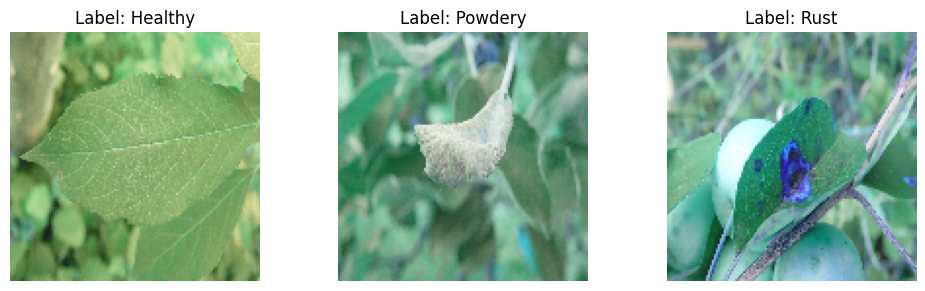

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
for i, label in enumerate(np.unique(y_train)):
    idx = np.where(y_train == label)[0][0]
    plt.subplot(1, 3, i + 1)
    plt.imshow(X_train[idx])
    plt.title(f"Label: {classes[label]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

PRA-PROSES CITRA

In [ ]:
def preprocess_image(img):
    # Resize
    img = cv2.resize(img, (256, 256))

    # Filter Median
    median = cv2.medianBlur(img, 5)

    # Konversi ke grayscale
    gray = cv2.cvtColor(median, cv2.COLOR_BGR2GRAY)

    # Operasi morfologi
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(gray, kernel, iterations=1)
    eroded = cv2.erode(dilated, kernel, iterations=1)

    return eroded

THRESHOLDING OTSU

In [ ]:
def apply_otsu(img_gray):
    thresh_val = threshold_otsu(img_gray)
    binary = (img_gray < thresh_val).astype(np.uint8) * 255
    return binary

SEGMENTASI & ANALISIS

In [ ]:
def segment_and_analyze(binary_img, original_img):
    # Deteksi tepi dengan Sobel
    edges = cv2.Sobel(binary_img, cv2.CV_64F, 1, 0, ksize=3)
    edges = np.uint8(np.absolute(edges))

    # Pelabelan komponen terhubung
    labels = measure.label(binary_img, connectivity=2)
    props = measure.regionprops(labels)

    # Perhitungan luas
    infected_area = np.sum(binary_img == 255)
    total_area = binary_img.size
    infected_percent = (infected_area / total_area) * 100

    # Bounding box overlay
    for prop in props:
        if prop.area > 100:  # threshold minimum area
            minr, minc, maxr, maxc = prop.bbox
            cv2.rectangle(original_img, (minc, minr), (maxc, maxr), (0, 255, 0), 2)
    return original_img, infected_percent

EVALUASI AKURASI SEDERHANA

In [ ]:
def dummy_ground_truth(binary_img):
    """Simulasi ground truth: Asumsikan hasil binerisasi Otsu sebagai pseudo ground truth"""
    return binary_img

def evaluate_accuracy(predicted, ground_truth):
    predicted = predicted.flatten() // 255
    ground_truth = ground_truth.flatten() // 255
    return accuracy_score(ground_truth, predicted)

EKSEKUSI

In [ ]:
def overlay_damage_area(original, binary_mask):
    # Buat salinan dari gambar asli
    overlay = original.copy()

    # Temukan kontur dari area rusak
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Gambar kontur dengan warna merah di atas salinan gambar asli
    cv2.drawContours(overlay, contours, -1, (255, 0, 0), 2)  # merah BGR

    return overlay

In [ ]:
def calculate_infection_percentage(binary_img):
    total_pixels = binary_img.size
    infected_pixels = np.sum(binary_img == 255)
    percent = (infected_pixels / total_pixels) * 100
    return percent

In [ ]:
disease_classes = ['Healthy', 'Powdery', 'Rust']
test_dir = '/content/Test/Test'

test_images, test_labels = load_images_from_folder(test_dir, limit=5)

for idx, (img, label) in enumerate(zip(test_images, test_labels)):
    processed = preprocess_image(img)
    binary = apply_otsu(processed)

    percent_infected = calculate_infection_percentage(binary)  # <== Tambahkan ini
    overlayed_img = overlay_damage_area(img, binary)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Citra Asli")

    plt.subplot(1, 3, 2)
    plt.imshow(binary, cmap='gray')
    plt.title("Citra Biner (Otsu)")

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(overlayed_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Segmentasi ({percent_infected:.2f}% rusak)")

    plt.tight_layout()
    plt.show()


NameError: name 'load_images_from_folder' is not defined

CNN

In [ ]:
label_dict = {'Healthy': 0, 'Powdery': 1, 'Rust': 2}

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
X_train, y_train = load_dataset_from_unzipped('Train/Train', image_size=(128, 128))
X_test, y_test = load_dataset_from_unzipped('Test/Test', image_size=(128, 128))
X_val, y_val = load_dataset_from_unzipped('Validation/Validation', image_size=(128, 128))

print("Train:", X_train.shape, y_train.shape)

Train: (1322, 128, 128, 3) (1322,)


In [ ]:
# Model CNN sederhana
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 kelas
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Training
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    batch_size=16
)

# Evaluasi
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\n✅ Akurasi CNN pada data uji: {test_acc * 100:.2f}%")

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 39s 450ms/step - accuracy: 0.4469 - loss: 1.9677 - val_accuracy: 0.7667 - val_loss: 0.6308
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 41s 451ms/step - accuracy: 0.7631 - loss: 0.5760 - val_accuracy: 0.6833 - val_loss: 0.6465
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 40s 443ms/step - accuracy: 0.8494 - loss: 0.4140 - val_accuracy: 0.7833 - val_loss: 0.4317
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 39s 422ms/step - accuracy: 0.9098 - loss: 0.2766 - val_accuracy: 0.8000 - val_loss: 0.4646
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 41s 424ms/step - accuracy: 0.9299 - loss: 0.1867 - val_accuracy: 0.8167 - val_loss: 0.5092
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 53s 567ms/step - accuracy: 0.9350 - loss: 0.1527 - val_accuracy: 0.8500 - val_loss: 0.4122
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 70s 419ms/step - accuracy: 0.9568 - loss: 0.1205 - val_accuracy: 0.8667 - val_loss: 0.3752
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 42s 437ms/step - accuracy: 0.9622 - loss: 0.1399 - val_accu

 Timeline To-Do List (13–19 Mei 2025)
Selasa, 13 Mei 2025 — Analisis Dataset & Finalisasi Struktur Folder
* Memastikan struktur folder dataset (Train/Train/...) benar.

* Menyesuaikan kode agar path dataset cocok.

* Mengganti nama label (Brown Spot → Healthy, dst).

* Mengekstrak dan memuat data citra latih & uji ke dalam array.

Rabu, 14 Mei 2025 — Pra-pemrosesan & Segmentasi Citra
* Terapkan filter median dan konversi grayscale.

* Lakukan operasi morfologi (dilation + erosion).

* Terapkan Otsu's thresholding dan segmentasi.

* Hitung persentase kerusakan daun (% area terinfeksi).

Kamis, 15 Mei 2025 — Implementasi CNN & Pelatihan Awal
* Bangun model CNN untuk klasifikasi (Healthy, Rust, Powdery).

* Load data citra dengan resize ke 128x128.

* Training model dengan data Train, validasi dengan Validation.

* Simpan model CNN terbaik (.h5).

Jumat, 16 Mei 2025 — Evaluasi & Integrasi Segmentasi + CNN
* Evaluasi CNN pada data Test (akurasi, confusion matrix).

* Gabungkan hasil CNN + segmentasi (bounding box + prediksi label).

* Tampilkan hasil per citra: gambar asli + segmentasi + label prediksi.

Sabtu, 17 Mei 2025 — Perbandingan Metode & Akurasi
* Uji metode segmentasi saja vs segmentasi+CNN.

* Hitung akurasi segmentasi terhadap ground truth manual.

* Bandingkan akurasi dengan literatur (misalnya 73.3%).

Minggu, 18 Mei 2025 — Visualisasi & Pembuatan Laporan
* Buat visualisasi hasil segmentasi + CNN (matplotlib).

* Simpan hasil per citra dalam bentuk gambar atau PDF.

* Buat ringkasan otomatis: label penyakit + persentase kerusakan.